In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
def load_data():
    (x_train, _), (x_test, _) = mnist.load_data()  # Load both train and test data
    x_train = (x_train / 255.0).reshape(-1, 784)  # Normalize and flatten train data
    x_test = (x_test / 255.0).reshape(-1, 784)    # Normalize and flatten test data
    return x_train, x_test

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# RBM Class
class RBM:
    def __init__(self, visible_size, hidden_size):
        self.m = visible_size
        self.n = hidden_size
        self.W = np.random.normal(0, 0.01, (self.m, self.n))  # Weight matrix
        self.a = np.zeros(self.m)  # Visible bias
        self.b = np.zeros(self.n)  # Hidden bias

    def sample_prob(self, probs):
        return (probs > np.random.rand(*probs.shape)).astype(np.float32)

    def gibbs_sampling(self, v):
        # Positive phase
        h_prob = sigmoid(np.dot(v, self.W) + self.b)  # Hidden activations
        h_sample = self.sample_prob(h_prob)

        # Negative phase
        v_prob = sigmoid(np.dot(h_sample, self.W.T) + self.a)  # Reconstruct visible
        v_sample = self.sample_prob(v_prob)

        h_prob_neg = sigmoid(np.dot(v_sample, self.W) + self.b)  # Recalculate hidden
        return v_prob, h_prob, v_sample, h_prob_neg

    def train(self, data, batch_size=100, learning_rate=0.1, epochs=10):
        for epoch in range(epochs):
            np.random.shuffle(data)
            mini_batches = [data[k:k + batch_size] for k in range(0, len(data), batch_size)]

            for batch in mini_batches:
                v0 = batch

                # Gibbs Sampling
                v1, h0, v1_sample, h1 = self.gibbs_sampling(v0)

                # Update weights and biases
                dW = np.dot(v0.T, h0) - np.dot(v1_sample.T, h1)
                da = np.mean(v0 - v1_sample, axis=0)
                db = np.mean(h0 - h1, axis=0)

                # Gradient update
                self.W += learning_rate * dW / batch_size
                self.a += learning_rate * da
                self.b += learning_rate * db

            print(f"Epoch {epoch + 1}/{epochs} completed.")

    def reconstruct(self, v):
        h = sigmoid(np.dot(v, self.W) + self.b)
        v_reconstructed = sigmoid(np.dot(h, self.W.T) + self.a)
        return v_reconstructed

# Load data
train_data, test_data = load_data()
train_data, val_data = train_data[:50000], train_data[50000:]

# Initialize and train RBM
visible_neurons = 784
hidden_neurons = 128
rbm = RBM(visible_size=visible_neurons, hidden_size=hidden_neurons)

# Train RBM
rbm.train(train_data, batch_size=10, learning_rate=0.1, epochs=1)

Epoch 1/1 completed.


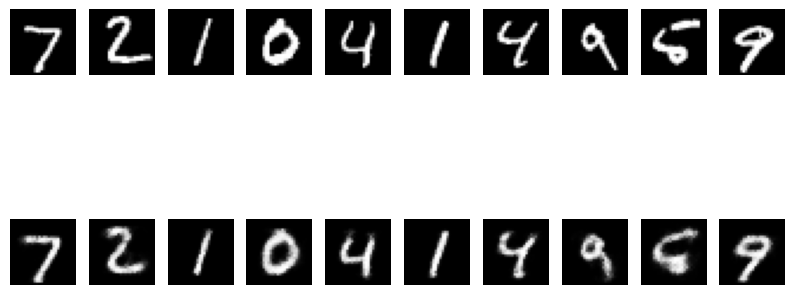

In [ ]:
# Test reconstruction
sample = test_data[:10]
reconstructed = rbm.reconstruct(sample)

# Visualize original and reconstructed images


plt.figure(figsize=(10, 5))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(sample[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()


Epoch 1/10, Loss: 2.3083
Epoch 2/10, Loss: 2.3019
Epoch 3/10, Loss: 2.2972
Epoch 4/10, Loss: 2.2939
Epoch 5/10, Loss: 2.2908
Epoch 6/10, Loss: 2.2881
Epoch 7/10, Loss: 2.2860
Epoch 8/10, Loss: 2.2833
Epoch 9/10, Loss: 2.2825
Epoch 10/10, Loss: 2.2809


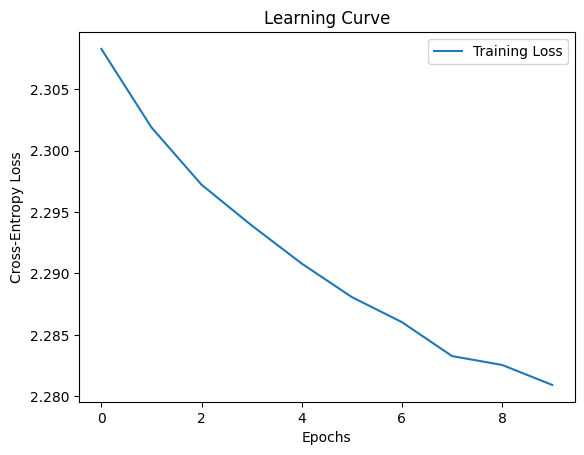

Test Loss: 2.3237


In [ ]:
from sklearn.metrics import log_loss

class OneLayerClassifier:
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, 0.01, (input_size, output_size))  # Classifier weights
        #self.bias = np.zeros(output_size)  # Classifier bias

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def predict(self, x):
        logits = np.dot(x, self.weights) #+ self.bias
        return self.softmax(logits)

    def train(self, x_train, y_train, batch_size, learning_rate, epochs):
        num_samples = x_train.shape[0]
        num_classes = self.weights.shape[1]
        y_one_hot = np.eye(num_classes)[y_train]  # Convert labels to one-hot encoding

        losses = []

        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_one_hot = y_one_hot[indices]

            batch_losses = []

            for i in range(0, num_samples, batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_one_hot[i:i + batch_size]

                # Forward pass
                logits = np.dot(x_batch, self.weights) # + self.bias
                predictions = self.softmax(logits)

                # Compute cross-entropy loss
                loss = -np.mean(np.sum(y_batch * np.log(predictions + 1e-9), axis=1))
                batch_losses.append(loss)

                # Backpropagation
                grad_logits = (predictions - y_batch) / batch_size
                grad_weights = np.dot(x_batch.T, grad_logits)
                grad_bias = np.sum(grad_logits, axis=0)

                # Gradient descent update
                self.weights -= learning_rate * grad_weights
                #self.bias -= learning_rate * grad_bias

            # Average loss for the epoch
            epoch_loss = np.mean(batch_losses)
            losses.append(epoch_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

        return losses

# Prepare RBM hidden activations as features for the classifier
def get_rbm_features(rbm, data):
    hidden_probs = sigmoid(np.dot(data, rbm.W) + rbm.b)
    return hidden_probs

# Data preparation
train_data, test_data = load_data()
train_data, val_data = train_data[:50000], train_data[50000:]
train_labels = np.random.randint(0, 10, size=50000)  # Dummy labels for training
val_labels = np.random.randint(0, 10, size=10000)  # Dummy labels for validation
test_labels = np.random.randint(0, 10, size=test_data.shape[0])  # Dummy labels for testing

# Extract features from RBM
val_features = get_rbm_features(rbm, val_data)
test_features = get_rbm_features(rbm, test_data)

# Initialize and train the 1-layer classifier
input_size = val_features.shape[1]
output_size = 10
classifier = OneLayerClassifier(input_size=input_size, output_size=output_size)

# Train the classifier on validation data
losses = classifier.train(val_features, val_labels, batch_size=100, learning_rate=0.1, epochs=1)

# Plot the learning curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Evaluate on test data
test_predictions = classifier.predict(test_features)
test_loss = log_loss(test_labels, test_predictions)
print(f"Test Loss: {test_loss:.4f}")
